# 动量策略-Momentum Strategy

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import warnings; warnings.simplefilter('ignore')       #忽略警告信息；

#### 前导知识及复习

In [2]:
import numpy as np
import pandas as pd
import tushare as ts

In [3]:
np.sign(-0.02)                  #重要函数；

-1.0

In [4]:
date = '2014-01-20'
type(date)

str

In [5]:
data = pd.to_datetime('2014-01-20') 
type(data)#转换成为时间数据；

pandas._libs.tslib.Timestamp

#### 1. 数据准备 & 回测准备

In [6]:
data = ts.get_k_data('hs300', start = '2010-01-01', end='2017-06-30')[['date','close']]

In [7]:
data.rename(columns={'close': 'price'}, inplace=True)

In [8]:
data.set_index('date', inplace = True)

In [9]:
data.head()

,price
date,
2010-01-04,3536.221
2010-01-05,3564.038
2010-01-06,3542.209
2010-01-07,3472.313
2010-01-08,3480.403


#### 2. 策略开发思路

In [10]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))

In [11]:
data.head()

,price,returns
date,,
2010-01-04,3536.221,NaN
2010-01-05,3564.038,0.007836
2010-01-06,3542.209,-0.006144
2010-01-07,3472.313,-0.019930
2010-01-08,3480.403,0.002327


In [12]:
data['position'] = np.sign(data['returns'])     
#关键语句,np.sign()很多地方用到；向量化；

In [13]:
data.head()

,price,returns,position
date,,,
2010-01-04,3536.221,NaN,NaN
2010-01-05,3564.038,0.007836,1.0
2010-01-06,3542.209,-0.006144,-1.0
2010-01-07,3472.313,-0.019930,-1.0
2010-01-08,3480.403,0.002327,1.0


In [14]:
data['strategy'] = data['position'].shift(1) * data['returns']  
#计算Momentum策略收益；避免未来函数；

In [15]:
data.head(10)

,price,returns,position,strategy
date,,,,
2010-01-04,3536.221,NaN,NaN,NaN
2010-01-05,3564.038,0.007836,1.0,NaN
2010-01-06,3542.209,-0.006144,-1.0,-0.006144
2010-01-07,3472.313,-0.019930,-1.0,0.019930
2010-01-08,3480.403,0.002327,1.0,-0.002327
2010-01-11,3482.680,0.000654,1.0,0.000654
2010-01-12,3535.407,0.015026,1.0,0.015026
2010-01-13,3421.116,-0.032862,-1.0,-0.032862
2010-01-14,3469.616,0.014077,1.0,-0.014077


#### 3. 策略可视化

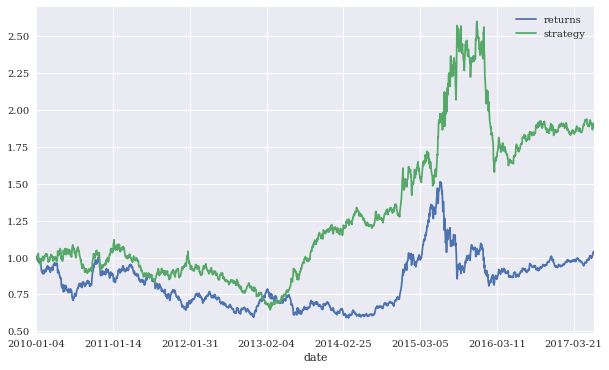

In [16]:
data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))    
#计算出策略的最终的累计收益；

策略的问题和思考？
过于频繁的买卖开仓；

#### 4. 策略优化之思路——参数优化和穷举

In [17]:
data['position_5'] = np.sign(data['returns'].rolling(5).mean()) 

In [18]:
data.head(20)

,price,returns,position,strategy,position_5
date,,,,,
2010-01-04,3536.221,NaN,NaN,NaN,NaN
2010-01-05,3564.038,0.007836,1.0,NaN,NaN
2010-01-06,3542.209,-0.006144,-1.0,-0.006144,NaN
2010-01-07,3472.313,-0.019930,-1.0,0.019930,NaN
2010-01-08,3480.403,0.002327,1.0,-0.002327,NaN
2010-01-11,3482.680,0.000654,1.0,0.000654,-1.0
2010-01-12,3535.407,0.015026,1.0,0.015026,-1.0
2010-01-13,3421.116,-0.032862,-1.0,-0.032862,-1.0
2010-01-14,3469.616,0.014077,1.0,-0.014077,-1.0


In [19]:
data['strategy_5'] = data['position_5'].shift(1) * data['returns']

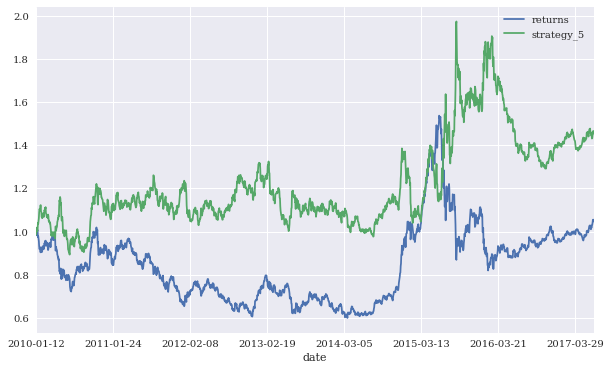

In [20]:
data[['returns', 'strategy_5']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6))

#### 参数寻优——使用离散Return计算方法

In [21]:
data['returns_dis'] = data['price'] / data['price'].shift(1)-1
#data['returns_dis'] = data['price'].pct_change()
data['returns_dis_cum'] = (data['returns_dis']+1).cumprod()
data.head()

,price,returns,position,strategy,position_5,strategy_5,returns_dis,returns_dis_cum
date,,,,,,,,
2010-01-04,3536.221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,3564.038,0.007836,1.0,NaN,NaN,NaN,0.007866,1.007866
2010-01-06,3542.209,-0.006144,-1.0,-0.006144,NaN,NaN,-0.006125,1.001693
2010-01-07,3472.313,-0.019930,-1.0,0.019930,NaN,NaN,-0.019732,0.981928
2010-01-08,3480.403,0.002327,1.0,-0.002327,NaN,NaN,0.002330,0.984215


In [22]:
price_plot = ['returns_dis_cum']    #这是用来绘制图形的一个list
type(price_plot)

list

In [23]:
for days in [10,20,30,60]:
#     data['position_%d' % days] = np.sign(data['returns'].rolling(days).mean())
    price_plot.append('sty_cumr_%dd' % days)
    data['position_%dd' % days] = np.where(data['returns'].rolling(days).mean()>0,1,-1)
    data['strategy_%dd' % days] = data['position_%dd' % days].shift(1) * data['returns']
    data['sty_cumr_%dd' % days] = (data['strategy_%dd' % days]+1).cumprod()

In [24]:
data.head()

,price,returns,position,strategy,position_5,strategy_5,returns_dis,returns_dis_cum,position_10d,strategy_10d,sty_cumr_10d,position_20d,strategy_20d,sty_cumr_20d,position_30d,strategy_30d,sty_cumr_30d,position_60d,strategy_60d,sty_cumr_60d
date,,,,,,,,,,,,,,,,,,,,
2010-01-04,3536.221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN
2010-01-05,3564.038,0.007836,1.0,NaN,NaN,NaN,0.007866,1.007866,-1,-0.007836,0.992164,-1,-0.007836,0.992164,-1,-0.007836,0.992164,-1,-0.007836,0.992164
2010-01-06,3542.209,-0.006144,-1.0,-0.006144,NaN,NaN,-0.006125,1.001693,-1,0.006144,0.998260,-1,0.006144,0.998260,-1,0.006144,0.998260,-1,0.006144,0.998260
2010-01-07,3472.313,-0.019930,-1.0,0.019930,NaN,NaN,-0.019732,0.981928,-1,0.019930,1.018155,-1,0.019930,1.018155,-1,0.019930,1.018155,-1,0.019930,1.018155
2010-01-08,3480.403,0.002327,1.0,-0.002327,NaN,NaN,0.002330,0.984215,-1,-0.002327,1.015785,-1,-0.002327,1.015785,-1,-0.002327,1.015785,-1,-0.002327,1.015785


In [25]:
price_plot

['returns_dis_cum',
 'sty_cumr_10d',
 'sty_cumr_20d',
 'sty_cumr_30d',
 'sty_cumr_60d']

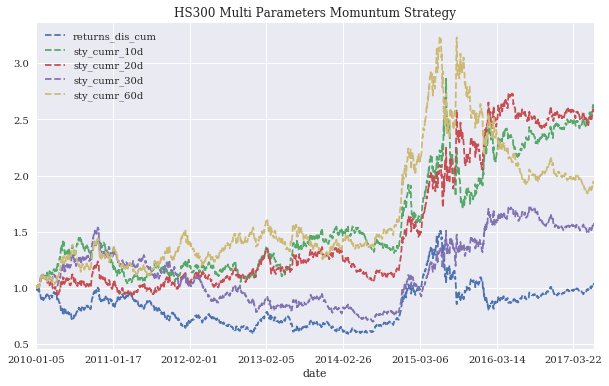

In [26]:
data[price_plot].dropna().plot(
    title='HS300 Multi Parameters Momuntum Strategy',
    figsize=(10, 6), style=['--', '--', '--', '--','--'])

#### 5. 策略优化思路之—— High Frequency Data用于Momentum策略

In [ ]:
hs300_hf = ts.get_k_data('hs300', ktype='5')

In [ ]:
hs300_hf.head(10)

In [ ]:
hs300_hf.set_index('date',inplace = True)

In [ ]:
hs300_hf.index = hs300_hf.index.to_datetime()      

In [ ]:
hs300_hf.info()            #Datetime时间数据；

In [ ]:
hs300_hf['2017-07-15':'2017-07-28'].head()

In [ ]:
hs300_hf['returns'] = np.log(hs300_hf['close'] / hs300_hf['close'].shift(1))

In [ ]:
hs300_hf['position'] = np.sign(hs300_hf['returns'].rolling(10).mean())     #10个5分钟平均；

In [ ]:
hs300_hf['strategy'] = hs300_hf['position'].shift(1) * hs300_hf['returns']

In [ ]:
hs300_hf[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6),
                                                                       style=['--', '--'])

声明：本资料仅限内部研究和交流使用，切勿外传。